In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from SAC.Agent import Agent
from Robot.Environment import Env
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, show   
from matplotlib import rcParams
from IPython import display
import time
import copy
import torch
import cv2
from IPython.display import clear_output

In [2]:
class Agent_Training():
    def __init__(self, subpolicy, image_dims, seed = 1):
        self.seed = seed
        self.image_dims = image_dims
        self.subpolicy = subpolicy
        self.static = False
        self.n_epochs = 250
        self.n_eval_episodes = 5
        self.n_test_episodes = 15
        self.episode_len = 100
        self.exploration_steps = 1000
        self.seq_len = 4
        
        self.env = Env(self.image_dims, self.seed)
        self.n_actions = self.env.action_space.shape[0]
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.agent = Agent(self.image_dims, self.n_actions, self.seq_len, self.env, self.seed) 
            
        if self.subpolicy > 1: self.trained_actors = self.get_trained_actors(target_subpolicy = self.subpolicy)
            
    """
    REMEMBER - WE PROCESS THE IMAGES INSIDE THE ENV CLASS, WHERE WE CONCATENATE THE TWO IMAGES (FRONT AND LEFT CAMERA) 
    AS 6 CHANNELS, RESHAPE TO (CHANNEL, HEIGHT, WEIDTH), AND THEN NORMALIZE (IMAGES / 255) - see: def my_render(image_dims)
    # already done in the environment class
    """
            
    #### function to 
    def integrate_weights(self):
        """
        - Specify which layers to transfer, and which to freeze
        """
        pass
    
    def get_tensor(self, observation):
        observation = torch.Tensor(observation).unsqueeze(0).to(self.device)
        return observation
    
    def get_trained_actors(self, target_subpolicy):
        """
        - Get the trained actor either to test, or to get to the initial state of the next subpolicy
        """
        trained_actors = []
        for i in range(1, target_subpolicy):
            new_agent = Agent(self.image_dims, self.n_actions, self.seq_len, self.env, self.seed) 
            trained_actor = new_agent.actor
            trained_actor.load_state_dict(torch.load(f'Models/models_sub_{i}/Actor'))
            trained_actor.eval()
            trained_actors.append(trained_actor)
        return trained_actors
    
    def update_sequences(self, seq_observation, seq_action, observation, actions):
        seq_observation = np.roll(seq_observation, -1, axis=0)
        seq_observation[-1] = observation
        seq_action = np.roll(seq_action, -1, axis=0)
        seq_action[-1] = actions
        return seq_observation, seq_action
    
    @torch.no_grad()
    def sample_actions(self, seq_observation, seq_action, actor, reparameterize):
        action, _ = actor.sample_normal(self.get_tensor(seq_observation), self.get_tensor(seq_action[1:]), reparameterize=reparameterize)
        action = action.cpu().detach().numpy()[0]
        return action
    
    def initial_window(self):
        """
        - Get the initial observation sequence for first subpolicy
        - We use neutral actions (0) to minimize the interactions with env
        """
        observation = self.env.reset()
        seq_observation = []
        seq_observation_ = []
        seq_actions = []        
        for i in range(self.seq_len): 
            subpolicy = 1
            action = [0 for i in range(self.n_actions)]
            observation_, _, done, _ = self.env.step(action, subpolicy, self.static)
            seq_observation.append(observation)
            seq_observation_.append(observation_)
            seq_actions.append(action)
            observation = observation_
        return np.array(seq_observation), np.array(seq_observation_), np.array(seq_actions, dtype=np.float64)
    

    def initial_window_all(self, subpolicy=None, train=False):
        """
        - Get the initial observation sequence for all subpolicy
        """
        if subpolicy is None: subpolicy = self.subpolicy

        if subpolicy == 1:
            final_seq_observation, final_seq_observation_, final_seq_actions = self.initial_window()
        else:
            succesfull = False
            for trained_subpolicy in range(1, subpolicy):
                trained_actor = self.trained_actors[trained_subpolicy - 1]            
                while not succesfull:
                    if trained_subpolicy == 1: seq_observation, _, seq_actions = self.initial_window()
                    seq_observation_ = copy.deepcopy(seq_observation)
                    last_seq_observation = []
                    last_seq_observation_ = []
                    last_seq_actions = []
                    for t in range(self.episode_len):
                        action = self.sample_actions(seq_observation, seq_actions, trained_actor, reparameterize=False)
                        observation_, _, done, succesfull = self.env.step(action, trained_subpolicy, self.static)
                        seq_observation_, seq_actions = self.update_sequences(seq_observation_, seq_actions, observation_, action)
                        last_seq_observation.append(seq_observation)
                        last_seq_observation_.append(seq_observation_)
                        last_seq_actions.append(seq_actions)
                        seq_observation = seq_observation_
                        if done: break
            final_seq_observation ,final_seq_observation_ , final_seq_actions = last_seq_observation[-1], last_seq_observation_[-1], last_seq_actions[-1]
        if train:
            for s in range(0, self.seq_len - 1):
                self.agent.remember(final_seq_observation[s], final_seq_actions[s], None, final_seq_observation_[s], 0)
            
        return final_seq_observation, final_seq_actions

    
    def initial_exploration(self):
        """
        - Explore the environomnt to fill in the buffer and exceed the batch size
        """
        seq_observation, seq_action = self.initial_window_all()        
        seq_observation_ = copy.deepcopy(seq_observation)
        for t in tqdm(range(self.exploration_steps)):
            action = self.sample_actions(seq_observation, seq_action, self.agent.actor, reparameterize=True)
            observation_, reward, done, _ = self.env.step(action, self.subpolicy, self.static)
            seq_observation_, seq_action = self.update_sequences(seq_observation_, seq_action, observation_, action)
            self.agent.remember(seq_observation[-1], seq_action[-1], reward, seq_observation_[-1], done)
            seq_observation = seq_observation_
            if done: 
                seq_observation, seq_action = self.initial_window_all()   
                seq_observation_ = copy.deepcopy(seq_observation)
        print('------------ Hey Fella, The Initial Exploration Has Just Finished -----------------')
        

    def train(self):
        """
        - Train the agent, save metrics for visualization, and save model
        """
        all_mean_rewards, all_actor_loss = [], []
        self.initial_exploration() 
        with tqdm(total = self.n_epochs) as pbar:
            for epoch in range(self.n_epochs):
                seq_observation, seq_action = self.initial_window_all()  
                seq_observation_ = copy.deepcopy(seq_observation)
                for t in range(self.episode_len):
                    action = self.sample_actions(seq_observation, seq_action, self.agent.actor,  reparameterize=True)
                    observation_, reward, done, info = self.env.step(action, self.subpolicy, self.static) 
                    seq_observation_, seq_action = self.update_sequences(seq_observation_, seq_action, observation_, action)
                    # ----------- Store Transitions --------------
                    self.agent.remember(seq_observation[-1], seq_action[-1], reward, seq_observation_[-1], done) #######  CHANGE HERE FOR BUFFER!!!
                    actor_loss = self.agent.learn()
                    seq_observation = seq_observation_
                    if done: break

                mean_rewards = self.validate_train()
                self.agent.save_models(self.subpolicy, epoch)
                all_mean_rewards.append(mean_rewards)
                all_actor_loss.append(actor_loss)
                print(f'Epoch: {epoch}, Rewards: {mean_rewards}, Actor Loss: {actor_loss}')

                plt.plot(all_mean_rewards)
                plt.show()
                display.display(plt.gcf())
                display.clear_output(wait=True)
                time.sleep(0.2)
                pbar.update(1)
        plt.plot(all_mean_rewards)
        
        # Save data as text file
        all_data = np.array([all_mean_rewards, all_actor_loss]).astype(float)
        all_data = all_data.T
        with open(f'Data/Data_sub_{self.subpolicy}.txt', 'w') as file:
            file.write('Rewards \tActor Loss\n')  # Write column headers
            np.savetxt(file, all_data, delimiter='\t', fmt='%f')
        
        
    def validate_train(self):
        """
        - Validate the agent during training in every epoch
        """
        total_rewards = 0
        actor = self.agent.actor.eval()
        for _ in range(self.n_eval_episodes):
            episode_reward = 0
            seq_observation, seq_action = self.initial_window_all()
            seq_observation_ = copy.deepcopy(seq_observation)
            for t in range(self.episode_len):
                action = self.sample_actions(seq_observation, seq_action, actor, reparameterize=False)
                observation_, reward, done, info = self.env.step(action, self.subpolicy, self.static)
                if info: print('--------------- Succesful ---------------')
                episode_reward += reward
                seq_observation_, seq_action = self.update_sequences(seq_observation_, seq_action, observation_, action)
                seq_observation = seq_observation_
                if done: break
            total_rewards += episode_reward
        return total_rewards / self.n_eval_episodes
            
        
    def visualize_results(self):
        """
        - Generate figures from the training
        """
        plt.rcParams['font.family'] = 'DeJavu Serif'
        df = pd.read_csv(f'Data/Data_sub_{self.subpolicy}.txt', delimiter='\t')

        for i, column in enumerate(df.columns):
            column_data = df[column].values
            means = pd.Series(column_data).rolling(window = 8).mean().values
            stds = pd.Series(column_data).rolling(window = 8).std().values

            plt.figure(figsize=(10,5))
            plt.plot(means, label='Mean')
            plt.fill_between(range(len(means)), means-stds, means+stds, alpha=0.2, label='Standard Deviation')
            plt.legend()
            plt.title(f'Sub-policy {self.subpolicy}', size=18) 
            plt.xlabel('Epochs', size=15)
            plt.ylabel(f'{column}', size=15)
            plt.savefig(f'Figures/Figures_sub_{self.subpolicy}/{column}.png', dpi=300, bbox_inches='tight')
            plt.show()

            
    def test_actor_video(self, subpolicy = None):
        # extract the image from the robot 
        # store images in the frames
        # will need another list to store the states, use states as a label for the frames. then I'm going to use the states for labelling
        # states = seq_observation
        # familiarise with the fetch environment - what are the states, what are the actions, what are the rewards
        # contact him on the email he sent me 
         
        if subpolicy == None: subpolicy = self.subpolicy 
        # trained_actor = self.get_trained_actors(self.subpolicy + 1)[-1] # get the agent of interest
        frames = [] # store the frames for the video
        
        for i in range(self.n_test_episodes):
            seq_observation, seq_action = self.initial_window_all(subpolicy = subpolicy, train=False)
            seq_observation_ = copy.deepcopy(seq_observation)
            rewards = 0
            for t in range(self.episode_len):  
                # action = self.sample_actions(seq_observation, seq_action, reparameterize=False)
                # action = self.env.action_space.sample()
                action = [0., 0., 0.]
                view1, view2 = self.env.my_render(dims = self.image_dims) # two different views - front and left. Two images instead of 1, test 1 vs 2 views
                # whether 1 is enough or 2 for the same state is better/enhances the training process
                # concatenated_image = np.concatenate((view1, view2), axis=1) # concatenate the two images
                concatenated_image = np.concatenate([view1[:,:,::-1], view2[:,:,::-1]], axis=2).transpose(2, 1, 0) / 255.0 
                frames.append(concatenated_image)
                observation_, reward, done, succesful = self.env.step(action, self.subpolicy, static=False)
                rewards += reward
                seq_observation_, seq_action = self.update_sequences(seq_observation_, seq_action, observation_, action)
                seq_observation = seq_observation_
                if succesful: print('--- Hell Yeah ---')
                if done:
                    print("done")
                    break
            print(rewards)
            print(i)

        writer = cv2.VideoWriter(f'Videos/Subpolicy_{self.subpolicy}.mp4', cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 25, (frames[0].shape[1], frames[0].shape[0]))
        for frame in frames:
            writer.write(frame)
        writer.release()

        return frames
        
    def train_high_policy(self): 
        sub_actor_1, sub_actor_2,sub_actor_3 = self.get_trained_actors()[:]
        
        frames_all = []
        labels_all = []
        object_coorditanes = []
        subpolicy = 1
        for _ in range(10):#self.n_test_episodes):
            frames = []
            labels = []
            seq_observation, _ , seq_action = self.initial_window_1() 
            seq_observation_ = copy.deepcopy(seq_observation)
            rewards = 0
            completed = False
            sub_actor = sub_actor_1
            for t in range(self.episode_len):
                action = self.sample_actions(seq_observation, seq_action, reparameterize=False)
                view1, view2 = self.env.my_render()
                concatenated_image = np.concatenate((view1, view2), axis=1)
                frames.append(concatenated_image)
                
                observation_, reward, done, succesful = self.env.step(action, subpolicy, self.static)
                rewards += reward
                seq_observation_, seq_action = self.update_sequences(seq_observation_, seq_action, observation_, action)
                seq_observation = seq_observation_
                
                if succesful: 
                    if subpolicy == 1:
                        labels.append(1)
                        subpolicy = 2
                        sub_actor = sub_actor_2
                    elif subpolicy == 2:
                        labels.append(2)
                        subpolicy = 3
                        sub_actor = sub_actor_3
                    elif subpolicy == 3:
                        labels.append(3)
                        frames_all.append(frames)
                        labels_all.append(labels)
                        subpolicy = 1
                        break
                else: 
                    labels.append(0)
                    if done: 
                        subpolicy = 1
                        break
            print(rewards)
                
        frames_all = sum(frames_all, [])
        labels_all = sum(labels_all, [])
        writer = cv2.VideoWriter(f'Videos/Complete_task.mp4', cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), 25, (frames_all[0].shape[1], frames_all[0].shape[0]))
        for frame in frames_all:
            writer.write(frame)
        writer.release()

In [3]:
subpolicy = 1
self = Agent_Training(subpolicy = 1, image_dims = 64)
frames = self.test_actor_video(subpolicy = 1)

-21.927916734897952
0
-29.248176110621262
1
-26.99283435081768
2
-25.09027284370688
3
-21.81251808299739
4
-25.237218269252907
5
-29.220102271872207
6
-27.774168031387166
7
-21.361416917600497
8
-30.227836759520017
9
-26.57450158609342
10
-22.04503775213275
11
-20.998650806930204
12
-20.430052156480336
13
-21.824561183795083
14


In [6]:
side_images = []
for i in range(len(frames)):
    x = frames[i]
    # swap the first and last dimensions
    x = np.swapaxes(x, 0, 2)
    side_images.append(x[:, :, 3:])

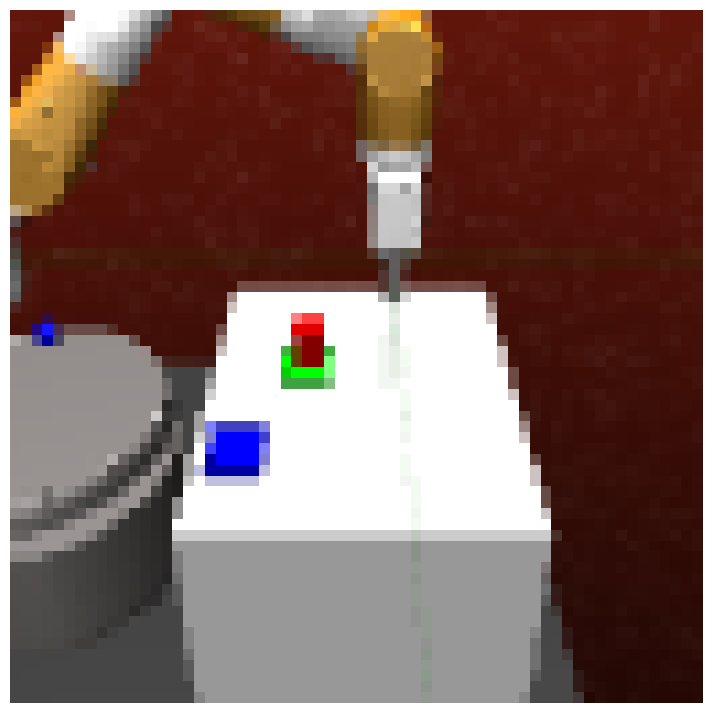

In [7]:
for image in side_images:
    plt.figure(figsize=(9, 9))
    plt.imshow(image)
    plt.axis('off')  # Turn off the axis
    plt.pause(0.005)  # Pause for 1 second between images
    # clear the current image
    clear_output(wait=True)